In [1]:
import  time
from    tqdm.notebook           import  tqdm

import  torch
from    torch                   import  Tensor
import  matplotlib.pyplot       as      plt
from    IPython                 import  display
from    ipywidgets              import  Output

import  append_path
from    deep_numerical.utils                   import  *
from    deep_numerical.numerical.distribution  import  *
from    deep_numerical.numerical.solvers       import  *

DTYPE:  torch.dtype     = torch.double
DEVICE: torch.device    = torch.device('cuda:3')
tensor_kwargs = {'dtype': DTYPE, 'device': DEVICE}

In [2]:
# Time
DELTA_T:    float       = 0.01
MIN_T:      float       = 0.0
MAX_T:      float       = 5
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      Tensor      = torch.linspace(MIN_T, MAX_T, NUM_T, **tensor_kwargs)

# Velocity
DIMENSION:      int         = 2
RESOLUTION:     int         = 2**5
MAX_V:          float       = 3.0 / LAMBDA
V:              Tensor      = velocity_grid(
                                    DIMENSION,
                                    RESOLUTION,
                                    MAX_V,
                                    where_closed='left',
                                    **tensor_kwargs
                                )

# Further configurations - FFT
FFT_NORM:   str         = 'forward'
_FREQ:      Tensor      = fft_index(RESOLUTION, **tensor_kwargs)
FREQ_MIN:   int         = int(_FREQ.min())
FREQ_MAX:   int         = int(_FREQ.max())
freqs:      Tensor      = freq_tensor(DIMENSION, RESOLUTION, **tensor_kwargs)
    
# VHS model
VSS_COEFF:      float   = 1 / area_of_unit_sphere(DIMENSION)
VSS_EXP_SPEED:  float   = 0.0
VSS_EXP_ANGLE:  float   = 0.0

# Metric
METRIC_ORDER:   float   = float('1')

# Problem type
PROBLEM_TYPE:   str = 'bimaxwellian' # 'bimaxwellian', 'bkw', 'maxwellian'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = get_bkw_coeff_ext(DIMENSION)

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = torch.ones((1,1), **tensor_kwargs)
MAXWELLIAN_MEAN_VELOCITY:       Tensor      = torch.zeros((1,DIMENSION), **tensor_kwargs)
MAXWELLIAN_MEAN_TEMPERATURE:    float       = torch.ones((1,1), **tensor_kwargs)

## Bimaxwellian distribution
BIMAXWELLIAN_MODE1_MEAN_DENSITY:     float       = 0.5 * torch.ones((1,1), **tensor_kwargs)
BIMAXWELLIAN_MODE1_MEAN_VELOCITY:    Tensor      = torch.tensor([[MAX_V/5, *zeros(DIMENSION-1)]], **tensor_kwargs)
BIMAXWELLIAN_MODE1_MEAN_TEMPERATURE: float       = 0.5 * torch.ones((1,1), **tensor_kwargs)

In [3]:
print(f"[ Initialization ]")
print(f"* Setting the initial value.")
init_f: Tensor
arr_f:  Tensor
if PROBLEM_TYPE == 'bkw':
    bkw_sol = bkw(
        ARR_T, V,
        coeff_ext   = BKW_COEFF_EXT,
        vhs_coeff   = VSS_COEFF,
    )
    init_f = bkw_sol[:, 0].clone()
elif PROBLEM_TYPE == 'maxwellian':
    init_f = maxwellian_homogeneous(
        V,
        MAXWELLIAN_MEAN_DENSITY,
        MAXWELLIAN_MEAN_VELOCITY,
        MAXWELLIAN_MEAN_TEMPERATURE,
    )
elif PROBLEM_TYPE == 'bimaxwellian':
    init_f = maxwellian_homogeneous(
        V,
        BIMAXWELLIAN_MODE1_MEAN_DENSITY,
        +BIMAXWELLIAN_MODE1_MEAN_VELOCITY,
        BIMAXWELLIAN_MODE1_MEAN_TEMPERATURE,
    ) + \
    maxwellian_homogeneous(
        V,
        BIMAXWELLIAN_MODE1_MEAN_DENSITY,
        -BIMAXWELLIAN_MODE1_MEAN_VELOCITY,
        BIMAXWELLIAN_MODE1_MEAN_TEMPERATURE,
    )

print(f"* Computing the kernel components.")
__config_shared: dict[str, object] = {
    'dimension':    DIMENSION,
    'v_num_grid':   RESOLUTION,
    'v_max':        MAX_V,
    'vhs_coeff':    VSS_COEFF,
    'restitution':  1.0,
    'dtype':        DTYPE,
    'device':       DEVICE,
}
solvers: list[FastSM_Boltzmann_VHS] = [
    FastSM_Boltzmann_VHS(**__config_shared, vhs_alpha=_vhs_alpha)
    for _vhs_alpha in [0.0, 0.25, 0.5, 0.75, 1.0]
]

fft_config = {'s': solvers[0].v_shape, 'dim': solvers[0].v_axes, 'norm': FFT_NORM}

[ Initialization ]
* Setting the initial value.
* Computing the kernel components.


In [4]:
# Define the function which returns the target
def return_target(t_idx: int) -> Tensor:
    if PROBLEM_TYPE == 'bkw':
        # Return the BKW solution at the given time index
        return bkw_sol[:, t_idx]
    elif PROBLEM_TYPE == 'maxwellian':
        # Return the initial value, which is the Maxwellian distribution
        return init_f
    elif PROBLEM_TYPE == 'bimaxwellian':
        # Return the Maxwellian distribution
        _batch_size, _data_dim = init_f.size(0), init_f.size(-1)
        _moments = compute_moments_homogeneous(init_f, V)
        return maxwellian_homogeneous(V, *_moments).reshape(
            _batch_size, *ones(DIMENSION), *solvers[0].v_shape, _data_dim
        )

In [5]:
# Define storages
arr_distribution:       list[list[Tensor]] = [[] for _ in range(len(solvers))]
arr_mean_density:       list[list[Tensor]] = [[] for _ in range(len(solvers))]
arr_mean_velocity:      list[list[Tensor]] = [[] for _ in range(len(solvers))]
arr_mean_temperature:   list[list[Tensor]] = [[] for _ in range(len(solvers))]
arr_rel_error:          list[list[Tensor]] = [[] for _ in range(len(solvers))]


# Define the function which updates the storages
def update_storages(t_idx: int, f: Tensor, solver_idx: int) -> None:
    _mean_density, _mean_velocity, _mean_temperature = \
        compute_moments_inhomogeneous(f, V, eps=1e-20)
    _target = return_target(t_idx)
    _rel_error = relative_error(f, _target, p=METRIC_ORDER)
    
    arr_distribution[solver_idx].append(f)
    arr_mean_density[solver_idx].append(_mean_density)
    arr_mean_velocity[solver_idx].append(_mean_velocity)
    arr_mean_temperature[solver_idx].append(_mean_temperature)
    arr_rel_error[solver_idx].append(_rel_error)

    return

In [6]:
print(f"[ Computation ]")
print(f"* Computing the numerical solution.")
_idx_start = 1
out = Output()
display.display(out)

for solver_idx, sm_object in enumerate(tqdm(solvers)):
    arr_f = init_f.clone()
    arr_f_fft: Tensor = torch.fft.fftn(arr_f, **fft_config)
    update_storages(0, init_f, solver_idx)
    for t_idx, t_curr in enumerate(tqdm(ARR_T[_idx_start:]), _idx_start):
        """Time marching from the temporal index `t_idx-1` to `t_idx`"""
        # Conduct time-marching
        t_prev = float(ARR_T[t_idx-1])
        arr_f_fft = sm_object.forward(t_prev, arr_f_fft, DELTA_T, one_step_RK4_classic)
        arr_f = torch.fft.ifftn(arr_f_fft, **fft_config).real
        # Save data
        update_storages(t_idx, arr_f, solver_idx)

print(f"* Stacking the results into tensors.")
ARR_T   = ARR_T.cpu()
V       = V.cpu()
for i in range(len(solvers)):
    arr_distribution[i]        = torch.stack(arr_distribution[i], dim=1).cpu()
    arr_mean_density[i]        = torch.stack(arr_mean_density[i], dim=1).cpu()
    arr_mean_velocity[i]       = torch.stack(arr_mean_velocity[i], dim=1).cpu()
    arr_mean_temperature[i]    = torch.stack(arr_mean_temperature[i], dim=1).cpu()
    arr_rel_error[i]           = torch.stack(arr_rel_error[i], dim=1).cpu()
print(f"\tDone.")

arr_distribution:       list[Tensor]
arr_mean_density:       list[Tensor]
arr_mean_velocity:      list[Tensor]
arr_mean_temperature:   list[Tensor]
arr_rel_error:          list[Tensor]

[ Computation ]
* Computing the numerical solution.


Output()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

* Stacking the results into tensors.
	Done.


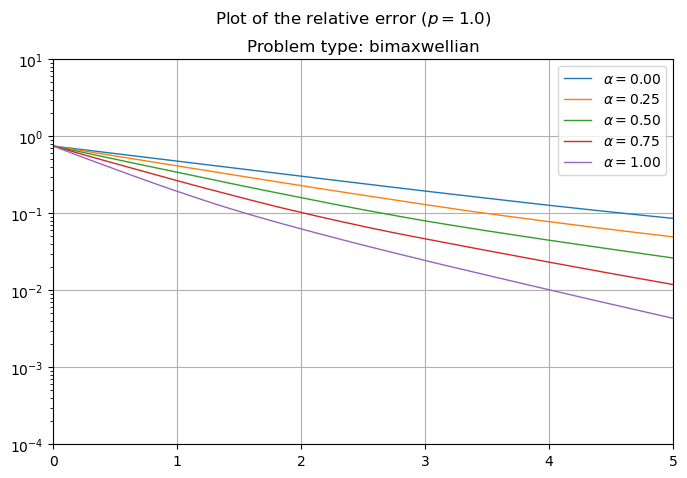

In [7]:
plt.figure(figsize=(8,5))
for idx in range(len(solvers)):
    plt.plot(ARR_T, arr_rel_error[idx].squeeze(), label=rf'$\alpha = {solvers[idx].vhs_alpha:.2f}$', linewidth=1)
plt.suptitle(f"Plot of the relative error ($p={METRIC_ORDER}$)")
plt.title(f"Problem type: {PROBLEM_TYPE}")
plt.xlim(MIN_T, MAX_T)
plt.ylim(1e-4, 1e+1)
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()

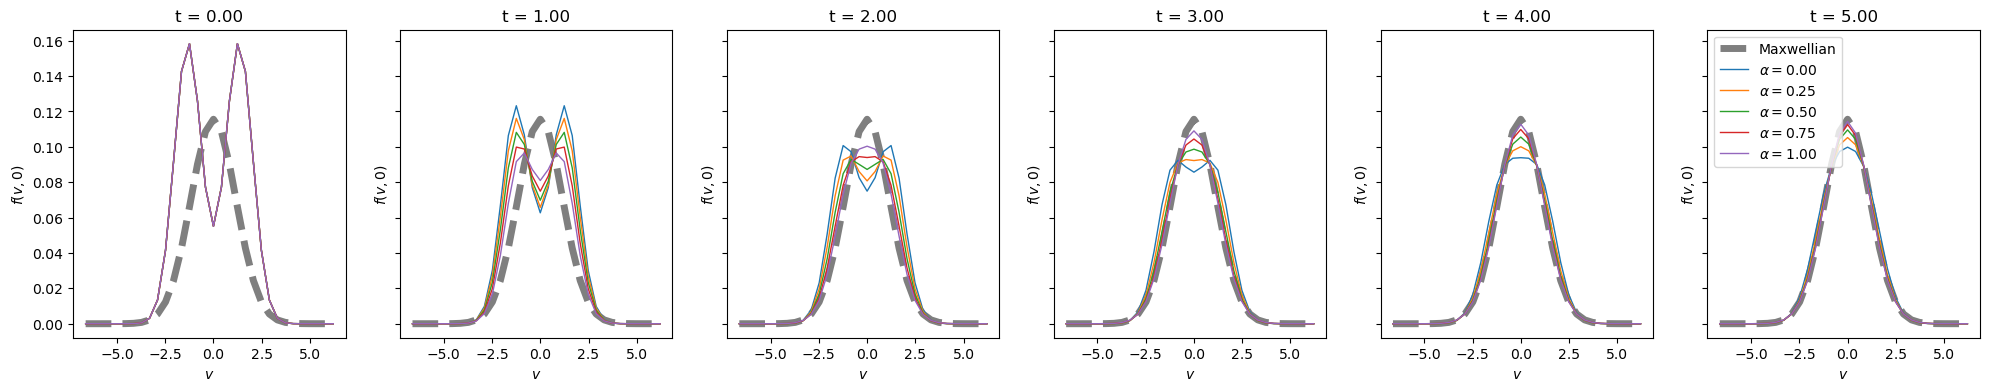

In [8]:
v_1d = velocity_grid(1, RESOLUTION, MAX_V, where_closed='left')
n_t = len(ARR_T)
denom = 5

list_t_idx = [*[(k*n_t)//denom for k in range(denom)], n_t-1][:6]
n_t_idx = len(list_t_idx)

_maxwellian = maxwellian_homogeneous(
    V,
    *compute_moments_homogeneous(init_f.clone().cpu(), V)
).reshape(RESOLUTION, RESOLUTION)
fig, axes = plt.subplots(1, n_t_idx, figsize=(4.1*n_t_idx, 4), sharex=True, sharey=True)
for ax_idx, t_idx in enumerate(list_t_idx):
    axes[ax_idx].set_xlabel(r'$v$')
    axes[ax_idx].set_ylabel(r'$f(v, 0)$')
    axes[ax_idx].plot(v_1d, _maxwellian[:, RESOLUTION//2], label='Maxwellian', color='black', linestyle='--', linewidth=5, alpha=0.5)
    for solver_idx, arr_dist in enumerate(arr_distribution):
        _arr_f = arr_dist[:, t_idx].reshape(RESOLUTION, RESOLUTION).cpu()
        axes[ax_idx].plot(
            v_1d, _arr_f[:, RESOLUTION//2],
            linewidth=1,
            label=rf'$\alpha = {solvers[solver_idx].vhs_alpha:.2f}$'
        )
        axes[ax_idx].set_title(f"t = {ARR_T[t_idx]:.2f}")
plt.legend()
plt.show()

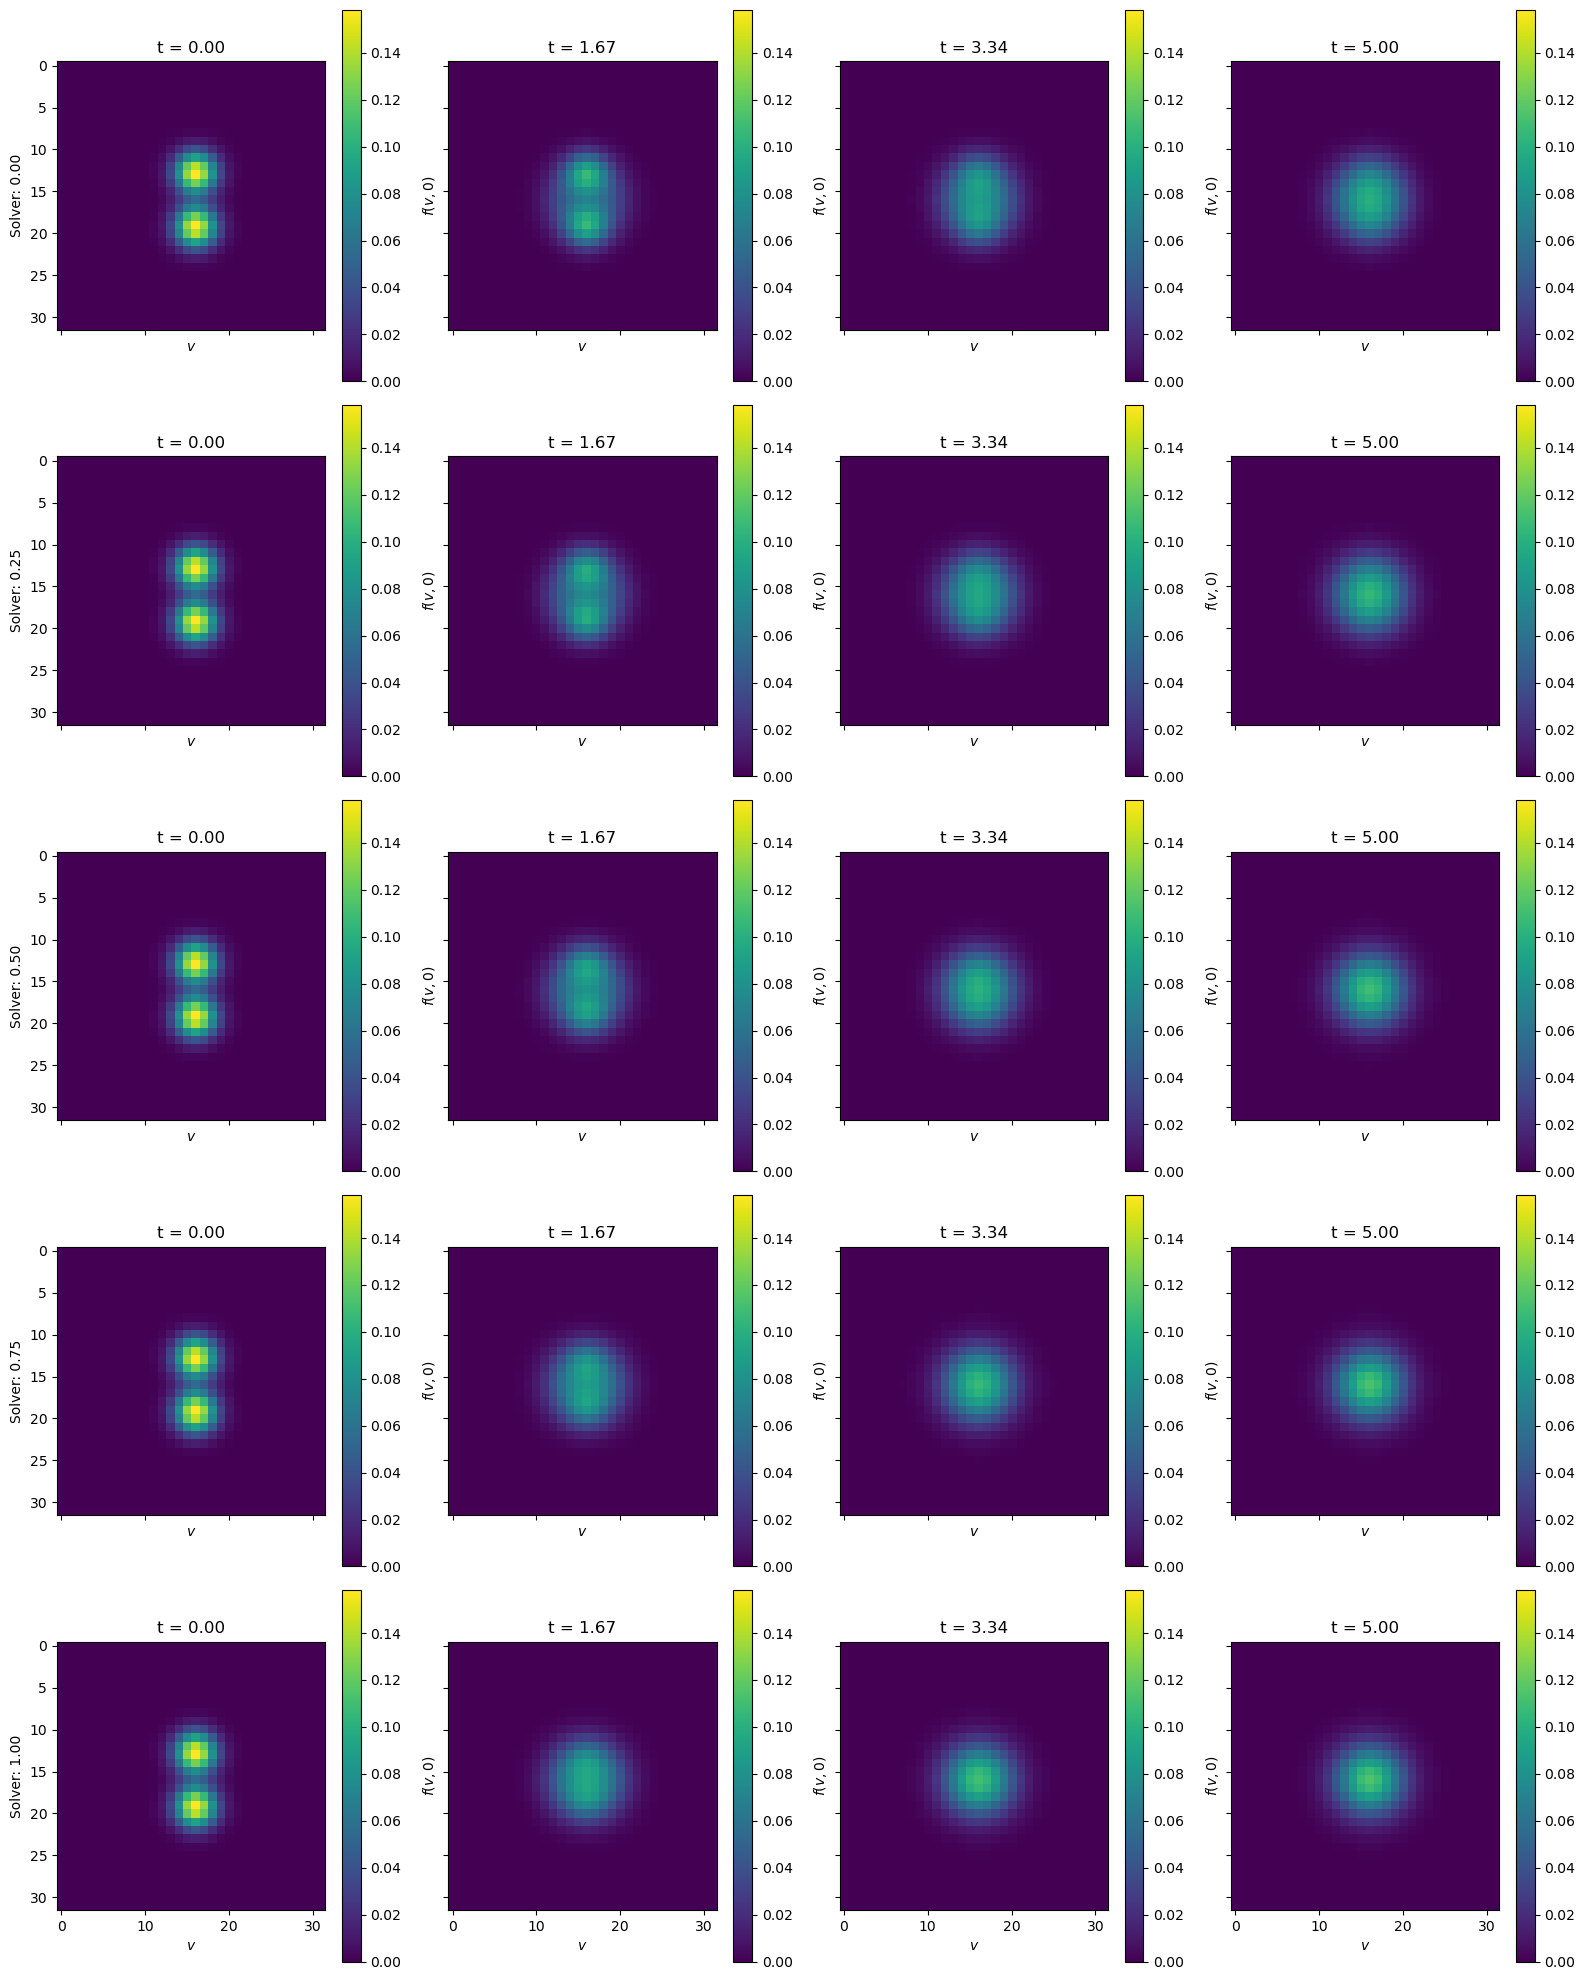

In [9]:
fig, axes = plt.subplots(len(solvers), 4, figsize=(16, 4*len(solvers)), sharex=True, sharey=True)
vmax = max((_arr.max().item() for _arr in arr_distribution))
for solver_idx, arr_dist in enumerate(arr_distribution):
    for ax_idx, t_idx in enumerate([0, NUM_T//3, 2*NUM_T//3, NUM_T-1]):
        _arr_f = arr_dist[:, t_idx].reshape(RESOLUTION, RESOLUTION).cpu()
        axes[solver_idx, ax_idx].set_xlabel(r'$v$')
        axes[solver_idx, ax_idx].set_ylabel(r'$f(v, 0)$')
        plt.colorbar(axes[solver_idx, ax_idx].imshow( _arr_f, vmax=vmax, vmin=0))
        axes[solver_idx, ax_idx].set_title(f"t = {ARR_T[t_idx]:.2f}")
    axes[solver_idx, 0].set_ylabel(f"Solver: {solvers[solver_idx].vhs_alpha:.2f}")
plt.tight_layout()
plt.show()

End of file